In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

random.seed(42)
np.random.seed(42)
plt.style.use('ggplot')

In [2]:
train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
X_test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

print(f"Train dataset shape: {train.shape}")
print(f"Test dataset shape: {X_test.shape}")

Train dataset shape: (42000, 785)
Test dataset shape: (28000, 784)


In [3]:
X_train = train.drop('label', axis=1)
y_train = train['label']

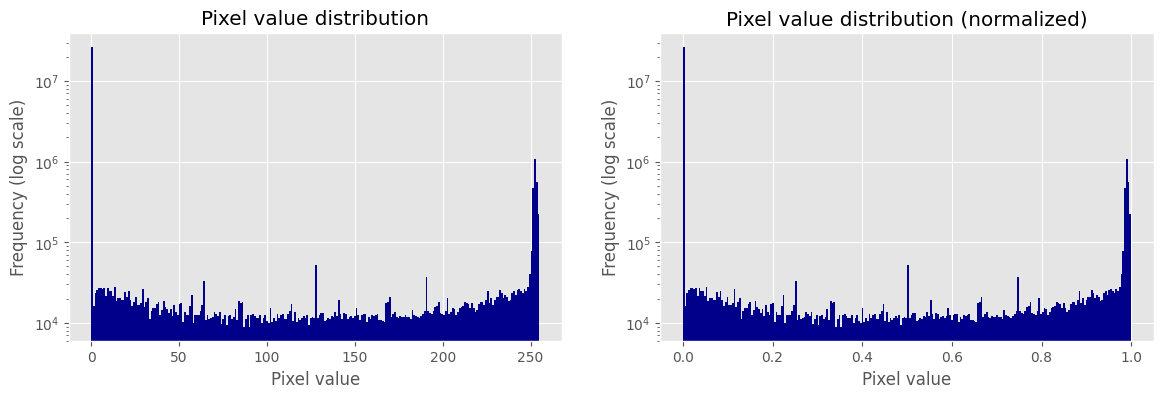

In [4]:
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.hist(X_train.values.flatten(), bins=256, color='darkblue')
plt.title('Pixel value distribution')
plt.xlabel('Pixel value')
plt.ylabel('Frequency (log scale)')
plt.yscale('log')

X_train = X_train / 255.0
X_test = X_test / 255.0

plt.subplot(1, 2, 2)
plt.hist(X_train.values.flatten(), bins=256, color='darkblue')
plt.title('Pixel value distribution (normalized)')
plt.xlabel('Pixel value')
plt.ylabel('Frequency (log scale)')
plt.yscale('log')
plt.show()

In [5]:
num_classes = y_train.max() + 1
y_train= np.eye(num_classes)[y_train]
y_train = y_train.astype(int)

In [6]:
def get_batch(X, y, batch_size):
    n_batches = X.shape[0] // batch_size
    for i in range(n_batches):
        X_batch = X[i*batch_size:(i+1)*batch_size]
        y_batch = y[i*batch_size:(i+1)*batch_size]
        yield X_batch, y_batch

In [7]:
def relu(x):
    return np.maximum(x, 0)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def cross_entropy_loss(y_true, y_pred):
    return -np.sum(y_true * np.log(y_pred)) / y_true.shape[0]

def accuracy(y_true, y_pred):
    return np.mean(np.argmax(y_true, axis=1) == np.argmax(y_pred, axis=1))

def forward(X, W1, b1, W2, b2):
    z1 = X @ W1 + b1
    a1 = relu(z1)
    z2 = a1 @ W2 + b2
    a2 = softmax(z2)
    return z1, a1, z2, a2

def backward(X, y, z1, a1, z2, a2, W1, W2, b1, b2):
    m = X.shape[0]
    dz2 = a2 - y
    dW2 = a1.T @ dz2 / m
    db2 = np.sum(dz2, axis=0) / m
    da1 = dz2 @ W2.T
    dz1 = da1 * relu_derivative(z1)
    dW1 = X.T @ dz1 / m
    db1 = np.sum(dz1, axis=0) / m
    return dW1, db1, dW2, db2

def train(X, y, W1, b1, W2, b2, learning_rate, epochs, batch_size):
    accs = []
    losses = []
    loop = tqdm(range(epochs))
    for epoch in loop:
        for X_batch, y_batch in get_batch(X, y, batch_size):
            z1, a1, z2, a2 = forward(X_batch, W1, b1, W2, b2)
            dW1, db1, dW2, db2 = backward(X_batch, y_batch, z1, a1, z2, a2, W1, W2, b1, b2)
            W1 -= learning_rate * dW1
            b1 -= learning_rate * db1
            W2 -= learning_rate * dW2
            b2 -= learning_rate * db2
        _, _, _, a2 = forward(X, W1, b1, W2, b2)
        loss = cross_entropy_loss(y, a2)
        acc = accuracy(y, a2)
        accs.append(acc)
        losses.append(loss)
        loop.set_postfix(loss=loss, acc=acc)
    return W1, b1, W2, b2, accs, losses

def predict(X, W1, b1, W2, b2):
    _, _, _, a2 = forward(X, W1, b1, W2, b2)
    return a2

def init_weights(input_size, hidden_size, output_size):
    W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2 / input_size)
    b1 = np.zeros(hidden_size)
    W2 = np.random.randn(hidden_size, output_size) * np.sqrt(2 / hidden_size)
    b2 = np.zeros(output_size)
    return W1, b1, W2, b2

input_size = X_train.shape[1]
hidden_size = 128
output_size = num_classes
learning_rate = 0.01
epochs = 100
batch_size = 32

W1, b1, W2, b2 = init_weights(input_size, hidden_size, output_size)
W1, b1, W2, b2, accs, losses = train(X_train.values, y_train, W1, b1, W2, b2, learning_rate, epochs, batch_size)

100%|██████████| 100/100 [04:19<00:00,  2.60s/it, acc=0.996, loss=0.0247]


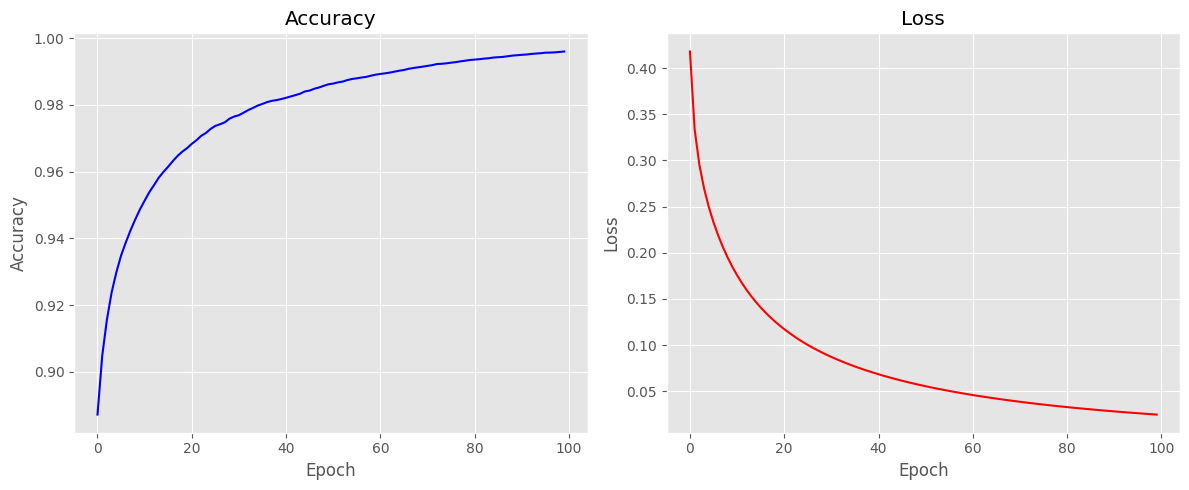

In [8]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(accs, color='b')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.subplot(1, 2, 2)
plt.plot(losses, color='r')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()
plt.show()

In [9]:
y_test = predict(X_test.values, W1, b1, W2, b2)
y_test = np.argmax(y_test, axis=1)

submission = pd.DataFrame({'ImageId': range(1, y_test.shape[0] + 1), 'Label': y_test})
submission.to_csv('submission.csv', index=False)